In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
# Load data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:5000].astype('float32') / 255.
x_test = x_test[:1000].astype('float32') / 255.
y_train = y_train[:5000]
y_test = y_test[:1000]
print(np.unique(y_train))
print(np.unique(y_test))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Using TensorFlow backend.


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
(5000, 32, 32, 3)
(1000, 32, 32, 3)
(5000, 1)
(1000, 1)


In [3]:
# Resize images to make it more challenging
x_train = np.array([resize(img, (64, 64)) for img in x_train]).astype('float32')
x_test = np.array([resize(img, (64, 64)) for img in x_test]).astype('float32')

C:\Users\pmeji\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\pmeji\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
# Function to add salt and pepper noise
def salt_and_pepper(img):
    n_rows, n_cols, n_chann = img.shape
    for row in range(n_rows):
        for col in range(n_cols):
            thresh = np.random.rand()
            if thresh > 0.9:
                img[row, col, :] = 1
            elif thresh < 0.1:
                img[row, col, :] = 0
    return img

In [5]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy()) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy()) for img in x_test]).astype('float32')

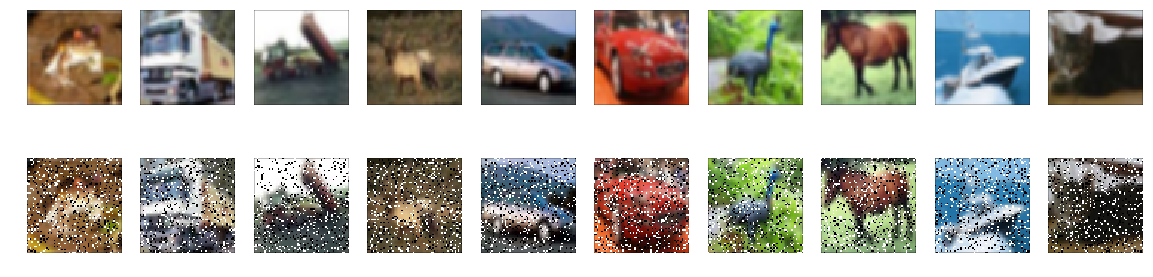

In [6]:
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

In [7]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape

### 0. Original

In [8]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         584       
__________

In [9]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam')

In [10]:
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 195s 49ms/step - loss: 0.0709 - val_loss: 0.0469
Epoch 2/10
4000/4000 [==============================] - 184s 46ms/step - loss: 0.0411 - val_loss: 0.0458
Epoch 3/10
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0331 - val_loss: 0.0342
Epoch 4/10
4000/4000 [==============================] - 81s 20ms/step - loss: 0.0290 - val_loss: 0.0265
Epoch 5/10
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0266 - val_loss: 0.0250
Epoch 6/10
4000/4000 [==============================] - 77s 19ms/step - loss: 0.0248 - val_loss: 0.0236
Epoch 7/10
4000/4000 [==============================] - 77s 19ms/step - loss: 0.0234 - val_loss: 0.0226
Epoch 8/10
4000/4000 [==============================] - 75s 19ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 9/10
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 10/10
40

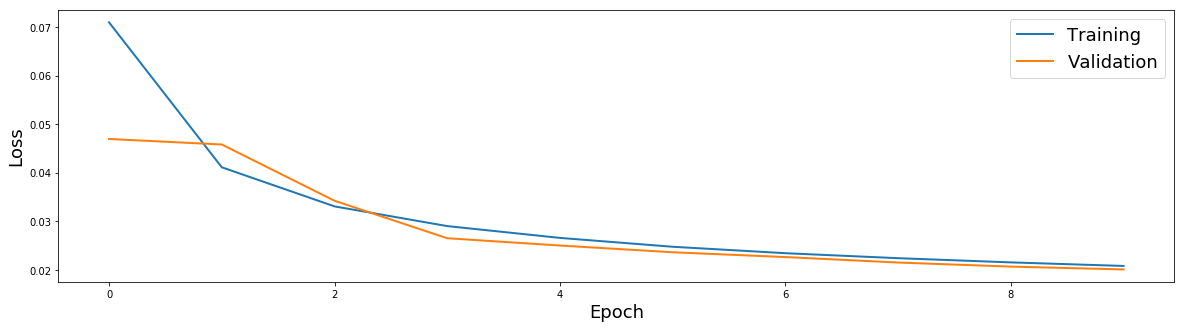

In [11]:
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

### 1. Mantienendo el número y orden inicial de layers, modifica el número de filtros o perceptrones

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
__________

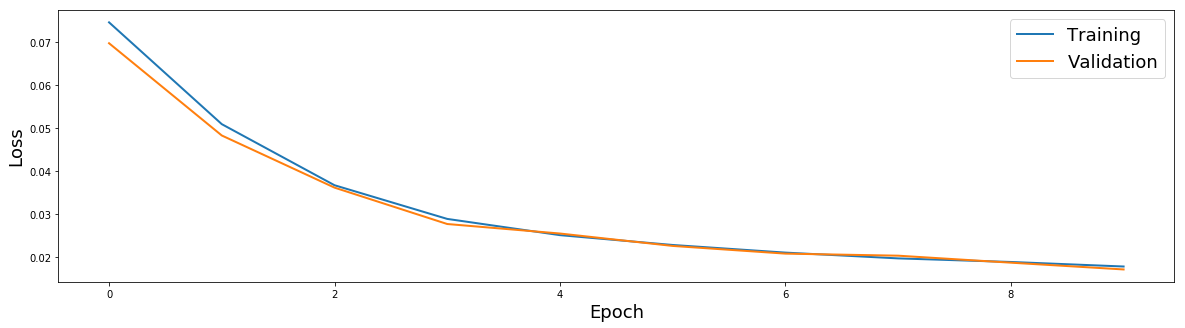

In [12]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2)
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 2. Explora diferentes tamaños de batch y número de épocas.


#### Exploración de tamaños de batch

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 550s 138ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 2/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 3/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0077 - val_loss: 0.0098
Epoch 4/10
4000/4000 [==============================] - 544s 136ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 5/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 6/10
4000/4000 [==============================] - 549s 137ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 7/10
4000/4000 [==============================] - 545s 136ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 8/10
4000/4000 [==============================] - 545s 136ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 9/10
4000/4000 [==============================] - 544s 136ms/step - loss: 0.0075 - val_loss: 0.008

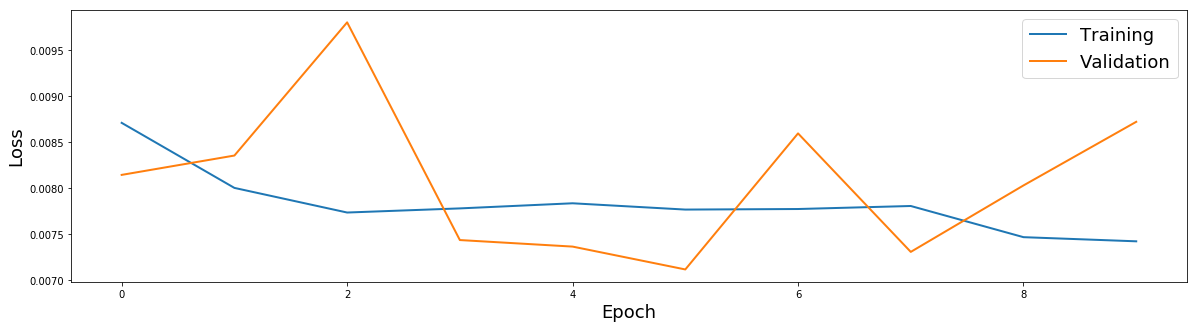

In [22]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2)
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es_bc = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 548s 137ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 2/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 3/10
4000/4000 [==============================] - 554s 139ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 4/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 5/10
4000/4000 [==============================] - 546s 137ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 6/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 7/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 8/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0065 - val_loss: 0.006

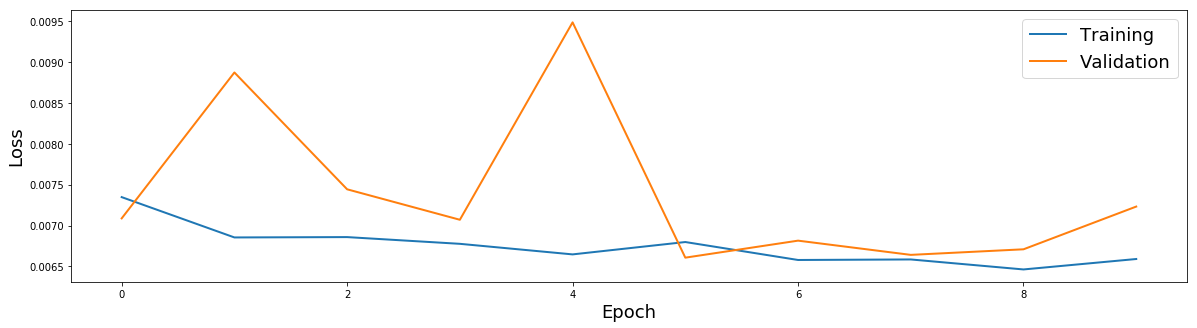

In [24]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 64
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 550s 137ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 2/10
4000/4000 [==============================] - 546s 137ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 3/10
4000/4000 [==============================] - 566s 141ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 4/10
4000/4000 [==============================] - 555s 139ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 5/10
4000/4000 [==============================] - 546s 137ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 6/10
4000/4000 [==============================] - 552s 138ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 7/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 8/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 9/10
4000/4000 [==============================] - 545s 136ms/step - loss: 0.0060 - val_loss: 0.006

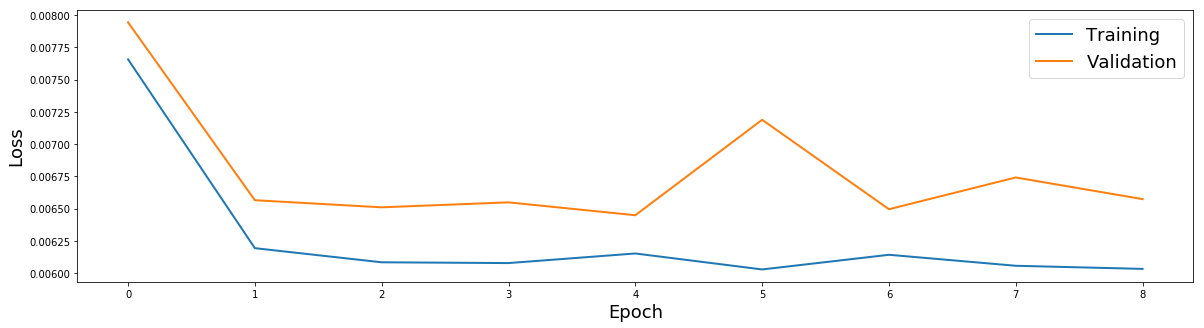

In [25]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 128
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 558s 140ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 2/10
4000/4000 [==============================] - 549s 137ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 3/10
4000/4000 [==============================] - 17749s 4s/step - loss: 0.0059 - val_loss: 0.0066
Epoch 4/10
4000/4000 [==============================] - 2207s 552ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 5/10
4000/4000 [==============================] - 554s 138ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 6/10
4000/4000 [==============================] - 548s 137ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 00006: early stopping


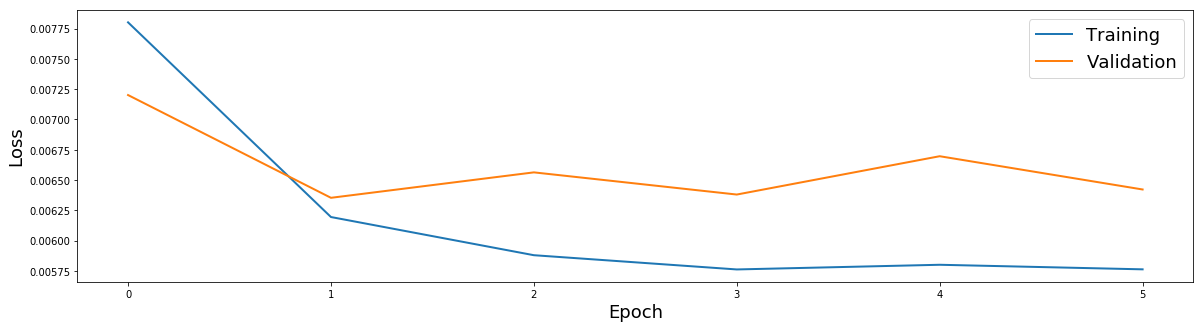

In [26]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 256
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

#### Exploración de número de épocas

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 549s 137ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 2/20
4000/4000 [==============================] - 540s 135ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 3/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 4/20
4000/4000 [==============================] - 539s 135ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 5/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 6/20
4000/4000 [==============================] - 540s 135ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/20
4000/4000 [==============================] - 540s 135ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/20
4000/4000 [==============================] - 539s 135ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 9/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.0068 - val_loss: 0.007

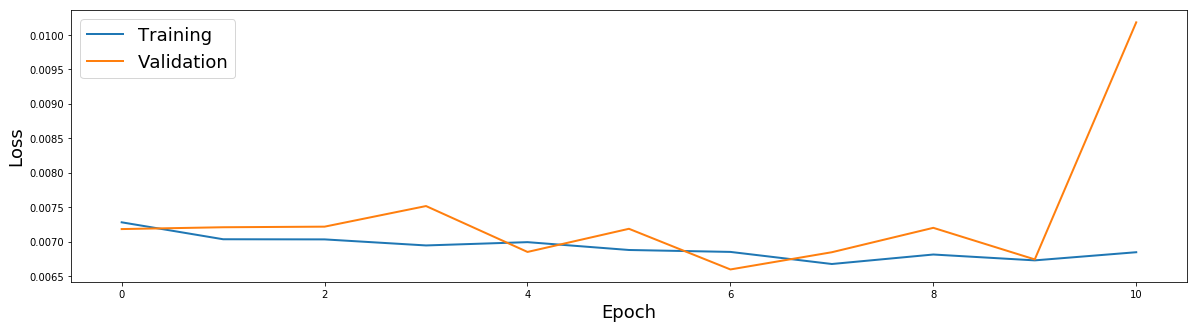

In [29]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 20
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5)) 
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 50
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 100
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 200
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 3. Modifica ahora el número, tipo y orden de layers.

In [ ]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 4. Evalua el desempeño usando sólo layers convolucionales.

In [ ]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [12]:
# Predict for test set
x_test_pred = model.predict(x_test_noise)

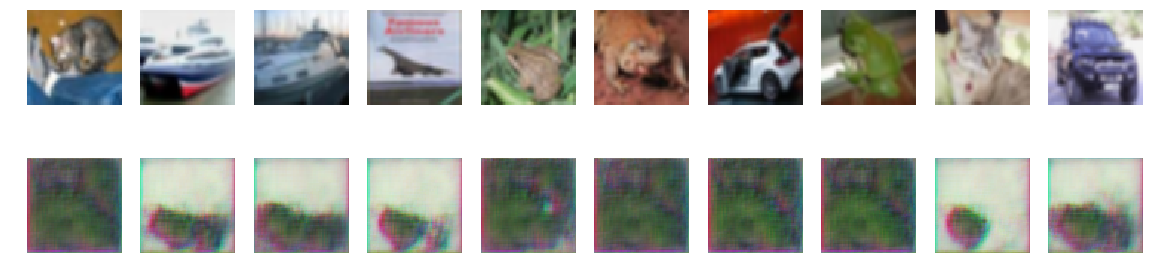

In [13]:
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()